### Giovanny Hidalgo - 3173810898 - cgiohidalgo@gmail.com

# Predicción de nivel de obesidad (Regresión)

Este notebook replica el flujo de clasificación, pero ahora como un problema de regresión, usando la variable `Obesity` transformada a numérica como `Obesity_numeric`.

## 1. Cargar librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from catboost import CatBoostRegressor

## 2. Cargar y explorar el dataset

In [3]:
# Instalar kagglehub (si no está instalado)
!pip install -q kagglehub

# Importar y descargar el dataset
import kagglehub

# Descargar la versión más reciente del dataset
path = kagglehub.dataset_download("ruchikakumbhar/obesity-prediction")

print("Path to dataset files:", path)

zsh:1: command not found: pip
Path to dataset files: /Users/cgiohidalgos/.cache/kagglehub/datasets/ruchikakumbhar/obesity-prediction/versions/1
Path to dataset files: /Users/cgiohidalgos/.cache/kagglehub/datasets/ruchikakumbhar/obesity-prediction/versions/1


In [4]:
import os

# Ver el contenido del directorio descargado
os.listdir(path)

['Obesity prediction.csv']

In [6]:
import pandas as pd

# Cargar el dataset
df = pd.read_csv(f"{path}/Obesity prediction.csv")

# Mostrar las primeras filas
df.head()


,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


## 3. Limpieza y preprocesamiento de datos

In [7]:
# Eliminar duplicados
df_clean = df.drop_duplicates().copy()
# Rellenar nulos numéricos con la media
num_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns
df_clean[num_cols] = df_clean[num_cols].fillna(df_clean[num_cols].mean())
# Rellenar nulos categóricos con la moda
cat_cols = df_clean.select_dtypes(include=['object']).columns
for col in cat_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])
# Normalizar variables numéricas
scaler = StandardScaler()
df_clean[num_cols] = scaler.fit_transform(df_clean[num_cols])
df_clean.head()

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,-0.526613,-0.887408,-0.872985,yes,no,-0.788364,0.390906,Sometimes,no,-0.007810,no,-1.186977,0.554211,no,Public_Transportation,Normal_Weight
1,Female,-0.526613,-1.960788,-1.178508,yes,no,1.082164,0.390906,Sometimes,yes,1.636552,yes,2.328908,-1.090505,Sometimes,Public_Transportation,Normal_Weight
2,Male,-0.212507,1.044677,-0.376509,yes,no,-0.788364,0.390906,Sometimes,no,-0.007810,no,1.156947,0.554211,Frequently,Public_Transportation,Normal_Weight
3,Male,0.415705,1.044677,0.005395,no,no,1.082164,0.390906,Sometimes,no,-0.007810,no,1.156947,-1.090505,Frequently,Walking,Overweight_Level_I
4,Male,-0.369560,0.830001,0.112328,no,no,-0.788364,-2.225418,Sometimes,no,-0.007810,no,-1.186977,-1.090505,Sometimes,Public_Transportation,Overweight_Level_II


## 4. Transformar la variable objetivo a numérica (`Obesity_numeric`)

In [8]:
# Codificar la variable Obesity como numérica
le = LabelEncoder()
df_clean['Obesity_numeric'] = le.fit_transform(df_clean['Obesity'])
df_clean[['Obesity', 'Obesity_numeric']].head()

,Obesity,Obesity_numeric
0,Normal_Weight,1
1,Normal_Weight,1
2,Normal_Weight,1
3,Overweight_Level_I,5
4,Overweight_Level_II,6


## 5. Codificar variables categóricas restantes

In [9]:
df_reg = df_clean.copy()
cat_cols = df_reg.select_dtypes(include=['object']).columns.drop('Obesity')
for col in cat_cols:
    le = LabelEncoder()
    df_reg[col] = le.fit_transform(df_reg[col])
df_reg.head()

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity,Obesity_numeric
0,0,-0.526613,-0.887408,-0.872985,1,0,-0.788364,0.390906,2,0,-0.007810,0,-1.186977,0.554211,3,3,Normal_Weight,1
1,0,-0.526613,-1.960788,-1.178508,1,0,1.082164,0.390906,2,1,1.636552,1,2.328908,-1.090505,2,3,Normal_Weight,1
2,1,-0.212507,1.044677,-0.376509,1,0,-0.788364,0.390906,2,0,-0.007810,0,1.156947,0.554211,1,3,Normal_Weight,1
3,1,0.415705,1.044677,0.005395,0,0,1.082164,0.390906,2,0,-0.007810,0,1.156947,-1.090505,1,4,Overweight_Level_I,5
4,1,-0.369560,0.830001,0.112328,0,0,-0.788364,-2.225418,2,0,-0.007810,0,-1.186977,-1.090505,2,3,Overweight_Level_II,6


## 6. Selección de variables independientes y dependiente

In [10]:
features = ['Gender', 'Age', 'Height', 'Weight', 'family_history', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS']
X = df_reg[features]
y = df_reg['Obesity_numeric']
print('Variables independientes:', X.columns.tolist())
print('Variable dependiente:', y.name)

Variables independientes: ['Gender', 'Age', 'Height', 'Weight', 'family_history', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS']
Variable dependiente: Obesity_numeric


## 7. Particionar en entrenamiento y prueba

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
print('Tamaño entrenamiento:', X_train.shape)
print('Tamaño prueba:', X_test.shape)

Tamaño entrenamiento: (1460, 16)
Tamaño prueba: (627, 16)


## 8. Entrenar modelo de regresión (CatBoostRegressor)

In [12]:
modelo = CatBoostRegressor(verbose=0, random_state=42)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)
y_pred[:10]

array([ 1.95007431,  3.05377655,  3.99449718, -0.01996026,  2.95191261,
        5.04313341,  4.94746533,  3.92140602,  0.5102131 ,  2.47709097])

## 9. Evaluar el modelo: métricas de regresión

In [13]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R2: {r2:.2f}')

MSE: 0.31
RMSE: 0.56
MAE: 0.32
R2: 0.92


## 10. Gráfico: valores reales vs predichos

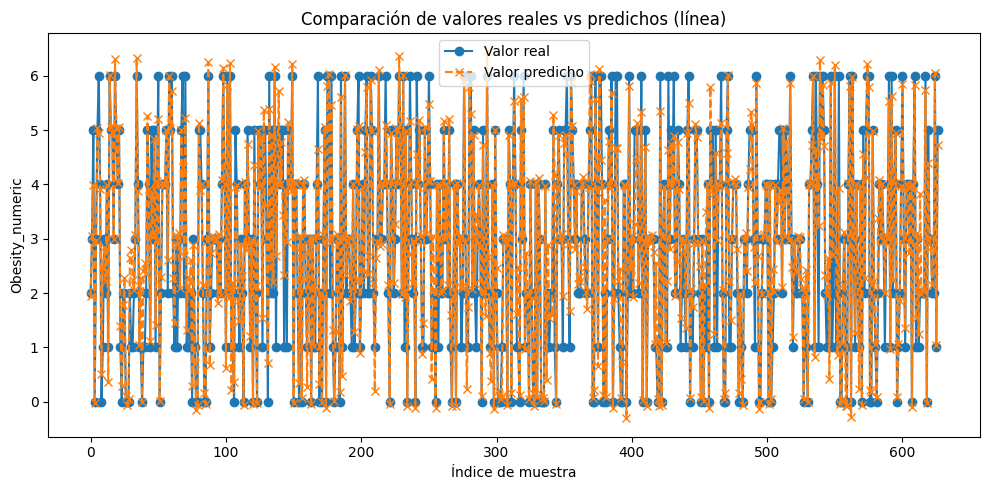

In [15]:
plt.figure(figsize=(10,5))
plt.plot(range(len(y_test)), y_test.values, label='Valor real', marker='o', linestyle='-')
plt.plot(range(len(y_pred)), y_pred, label='Valor predicho', marker='x', linestyle='--')
plt.xlabel('Índice de muestra')
plt.ylabel('Obesity_numeric')
plt.title('Comparación de valores reales vs predichos (línea)')
plt.legend()
plt.tight_layout()
plt.show()

## 11. Discusión de los resultados

El modelo de regresión CatBoostRegressor permite predecir el nivel de obesidad codificado numéricamente (`Obesity_numeric`) a partir de variables de estilo de vida y salud. A continuación se resumen los puntos clave:

- **Desempeño general:** Las métricas MSE, RMSE y MAE indican el error promedio de las predicciones. Un R2 cercano a 1 sugiere que el modelo explica bien la variabilidad de los datos, mientras que valores bajos indican margen de mejora.

- **Interpretación del gráfico:** El diagrama de líneas muestra la comparación entre los valores reales y los predichos para cada muestra. Si ambas líneas siguen trayectorias similares, el modelo está capturando bien la tendencia general. Grandes diferencias o cruces frecuentes pueden indicar errores sistemáticos o dificultad para predecir ciertos casos.

- **Posibles causas de error:**
    - El modelo puede tener dificultades si hay clases poco representadas o si la relación entre variables no es lineal.
    - La codificación numérica de una variable originalmente categórica puede introducir saltos artificiales entre clases.
    - Outliers o datos atípicos pueden afectar el ajuste.

- **Mejoras recomendadas:**
    - Probar otras técnicas de regresión o ajustar hiperparámetros del modelo.
    - Realizar ingeniería de variables para capturar mejor la información relevante.
    - Analizar la importancia de las variables para identificar los factores más influyentes.
    - Si el modelo sobreajusta (muy buen desempeño en entrenamiento pero no en prueba), aplicar regularización o validación cruzada.

**OJO VIVO AQUI:** El modelo logra predecir el nivel de obesidad con un error razonable, pero siempre es importante analizar los casos donde falla y buscar mejoras en el preprocesamiento, selección de variables y ajuste del modelo para obtener resultados más robustos y generalizables.